# 3-11. 프로젝트: 모델 성능 개선하기

Mecab, Kkma, Komoran, Hannanum, Okt 등 konlpy가 제공하는 형태소 분석기별로 각각 4가지 상황을 테스트해봤다. 데이터 크기와 불용어 종류를 두 가지씩으로 나눴다.   

데이터는 운영진에서 제공한 news_data.csv 한 가지와, news_data.csv + news_data2.csv 를 합한 데이터 두 경우를 테스트해봤다. 보다 대용량의 뉴스 데이터를 별도로 수집하고자 했으나, newspaper 모듈의 속도가 느리고 대량 수집에 대한 대비도 안 되어 있어 시간 관계상 주어진 데이터로 상황을 만들었다. 확인 결과 news_data.csv(중복 제거 후 3994건)와 news_data2.csv(중복 제거 후 2137건) 간 중복 데이터는 4건으로 많지 않았다.   

불용어 목록은 Exploration Stage에 주어진 예제와, 그 예제에 인터넷에서 구할 수 있는 대량 불용어 목록을 합한 두 경우를 테스트했다.   

결과적으로 kkma 형태소 분석기를 사용해, news_data.csv만을 대상으로 적은 불용어 목록을 적용했을 때 (케이스 3) F1 score가 0.83으로 가장 높았다.

## 필요한 모듈 import

In [1]:
import pandas as pd

import matplotlib.font_manager as fm # http://corazzon.github.io/matplotlib_font_setting
from matplotlib import rc
import matplotlib.pyplot as plt

from konlpy.tag import Mecab # mecab
from konlpy.tag import Kkma # kkma
from konlpy.tag import Komoran # komoran
from konlpy.tag import Hannanum # hannanum
# from konlpy.tag import Twitter # twitter
from konlpy.tag import Okt # Okt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

## 뉴스 데이터 전처리

### 데이터 로드

In [2]:
data = pd.read_csv("news_data.csv", sep=",")
# data.head()

code_list = data.drop_duplicates(subset='code')['code'].values # https://stackoverflow.com/questions/12497402/python-pandas-remove-duplicates-by-columns-a-keeping-the-row-with-the-highest

### 데이터 전처리

In [3]:
# 한글 외의 문자 전부 제거
data['news'] = data['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
print(data.isnull().sum()) # null 있는지 확인

# 중복 샘플 제거
print("중복 제거 전 데이터 수: " + str(len(data)))
data.drop_duplicates(subset=['news'], inplace=True)
print("중복 제거 후 데이터 수: " + str(len(data)))

news    0
code    0
dtype: int64
중복 제거 전 데이터 수: 5124
중복 제거 후 데이터 수: 3994


## 뉴스 데이터 탐색

### TODO: matplotlib 한글 폰트 적용

In [4]:
# 나눔폰트 설치: sudo apt-get install fonts-nanum*
# 폰트 이동: sudo cp /usr/share/fonts/truetype/nanum/Nanum* ~/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/

# 폰트 설정 (http://corazzon.github.io/matplotlib_font_setting)
font_path = '/usr/share/fonts/truetype/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

'''
print(plt.rcParams["font.family"]) # 설정된 폰트 확인 (http://corazzon.github.io/matplotlib_font_setting)
plt.rcParams["font.family"] = "NanumGothic" # 등록한 폰트 적용 (https://programmers.co.kr/learn/courses/21/lessons/950)
'''

rc('font', family="NanumGothic") # https://unsolvedproblem.github.io/etc/2020/08/04/matplotlib_korean_recog.html

# matplotlib 캐시 삭제 (https://analysis-flood.tistory.com/83)

    code  count
0  IT/과학    903
1     사회   1668
2  생활/문화   1423


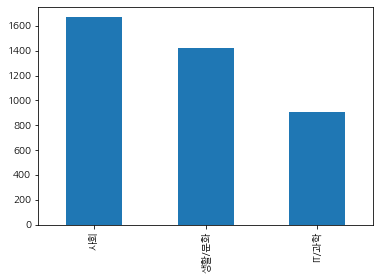

In [5]:
# 카테고리별 기사 수 확인
print(data.groupby('code').size().reset_index(name='count'))
data['code'].value_counts().plot(kind='bar')

## 전처리 및 불용어 제거 관련 사전 정의

In [6]:
# 형태소 분석기별 인스턴스화
mecab = Mecab()
kkma = Kkma()
komoran = Komoran() # Cannot access komoran-dic: https://github.com/konlpy/konlpy/issues/221
hannanum = Hannanum()
# twitter = Twitter()
okt = Okt()

# remove_stopwords (토큰화 + 불용어 제거) 함수 정의
def remove_stopwords(data, stopwords, tokenizer):
    result = []
    
    for sentence in data:
        curr_data = []
        curr_data = tokenizer.morphs(sentence) # 토큰화
        curr_data = [word for word in curr_data if not word in stopwords]
        
        result.append(curr_data)
        
    result = list(map(' '.join, result))
    return result

# 불용어 (stopwords) 정의
stopwords = ['에','는','은','을','했','에게','있',
             '이','의','하','한','다','과','때문',
             '할','수','무단','따른','및','금지','전재',
             '경향신문','기자','는데','가','등','들',
             '파이낸셜','저작','등','뉴스']

# https://www.ranks.nl/stopwords/korean 
stopwords_extra = ['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만', '하물며', '또한', '그러나', '그렇지만', '하지만', '이외에도', '대해 말하자면', '뿐이다', '다음에', '반대로', '반대로 말하자면', '이와 반대로', '바꾸어서 말하면', '바꾸어서 한다면', '만약', '그렇지않으면', '까악', '툭', '딱', '삐걱거리다', '보드득', '비걱거리다', '꽈당', '응당', '해야한다', '에 가서', '각', '각각', '여러분', '각종', '각자', '제각기', '하도록하다', '와', '과', '그러므로', '그래서', '고로', '한 까닭에', '하기 때문에', '거니와', '이지만', '대하여', '관하여', '관한', '과연', '실로', '아니나다를가', '생각한대로', '진짜로', '한적이있다', '하곤하였다', '하', '하하', '허허', '아하', '거바', '와', '오', '왜', '어째서', '무엇때문에', '어찌', '하겠는가', '무슨', '어디', '어느곳', '더군다나', '하물며', '더욱이는', '어느때', '언제', '야', '이봐', '어이', '여보시오', '흐흐', '흥', '휴', '헉헉', '헐떡헐떡', '영차', '여차', '어기여차', '끙끙', '아야', '앗', '아야', '콸콸', '졸졸', '좍좍', '뚝뚝', '주룩주룩', '솨', '우르르', '그래도', '또', '그리고', '바꾸어말하면', '바꾸어말하자면', '혹은', '혹시', '답다', '및', '그에 따르는', '때가 되어', '즉', '지든지', '설령', '가령', '하더라도', '할지라도', '일지라도', '지든지', '몇', '거의', '하마터면', '인젠', '이젠', '된바에야', '된이상', '만큼 	어찌됏든', '그위에', '게다가', '점에서 보아', '비추어 보아', '고려하면', '하게될것이다', '일것이다', '비교적', '좀', '보다더', '비하면', '시키다', '하게하다', '할만하다', '의해서', '연이서', '이어서', '잇따라', '뒤따라', '뒤이어', '결국', '의지하여', '기대여', '통하여', '자마자', '더욱더', '불구하고', '얼마든지', '마음대로', '주저하지 않고', '곧', '즉시', '바로', '당장', '하자마자', '밖에 안된다', '하면된다', '그래', '그렇지', '요컨대', '다시 말하자면', '바꿔 말하면', '즉', '구체적으로', '말하자면', '시작하여', '시초에', '이상', '허', '헉', '허걱', '바와같이', '해도좋다', '해도된다', '게다가', '더구나', '하물며', '와르르', '팍', '퍽', '펄렁', '동안', '이래', '하고있었다', '이었다', '에서', '로부터', '까지', '예하면', '했어요', '해요', '함께', '같이', '더불어', '마저', '마저도', '양자', '모두', '습니다', '가까스로', '하려고하다', '즈음하여', '다른', '다른 방면으로', '해봐요', '습니까', '했어요', '말할것도 없고', '무릎쓰고', '개의치않고', '하는것만 못하다', '하는것이 낫다', '매', '매번', '들', '모', '어느것', '어느', '로써', '갖고말하자면', '어디', '어느쪽', '어느것', '어느해', '어느 년도', '라 해도', '언젠가', '어떤것', '어느것', '저기', '저쪽', '저것', '그때', '그럼', '그러면', '요만한걸', '그래', '그때', '저것만큼', '그저', '이르기까지', '할 줄 안다', '할 힘이 있다', '너', '너희', '당신', '어찌', '설마', '차라리', '할지언정', '할지라도', '할망정', '할지언정', '구토하다', '게우다', '토하다', '메쓰겁다', '옆사람', '퉤', '쳇', '의거하여', '근거하여', '의해', '따라', '힘입어', '그', '다음', '버금', '두번째로', '기타', '첫번째로', '나머지는', '그중에서', '견지에서', '형식으로 쓰여', '입장에서', '위해서', '단지', '의해되다', '하도록시키다', '뿐만아니라', '반대로', '전후', '전자', '앞의것', '잠시', '잠깐', '하면서', '그렇지만', '다음에', '그러한즉', '그런즉', '남들', '아무거나', '어찌하든지', '같다', '비슷하다', '예컨대', '이럴정도로', '어떻게', '만약', '만일', '위에서 서술한바와같이', '인 듯하다', '하지 않는다면', '만약에', '무엇', '무슨', '어느', '어떤', '아래윗', '조차', '한데', '그럼에도 불구하고', '여전히', '심지어', '까지도', '조차도', '하지 않도록', '않기 위하여', '때', '시각', '무렵', '시간', '동안', '어때', '어떠한', '하여금', '네', '예', '우선', '누구', '누가 알겠는가', '아무도', '줄은모른다', '줄은 몰랏다', '하는 김에', '겸사겸사', '하는바', '그런 까닭에', '한 이유는', '그러니', '그러니까', '때문에', '그', '너희', '그들', '너희들', '타인', '것', '것들', '너', '위하여', '공동으로', '동시에', '하기 위하여', '어찌하여', '무엇때문에', '붕붕', '윙윙', '나', '우리', '엉엉', '휘익', '윙윙', '오호', '아하', '어쨋든', '만 못하다 	하기보다는', '차라리', '하는 편이 낫다', '흐흐', '놀라다', '상대적으로 말하자면', '마치', '아니라면', '쉿', '그렇지 않으면', '그렇지 않다면', '안 그러면', '아니었다면', '하든지', '아니면', '이라면', '좋아', '알았어', '하는것도', '그만이다', '어쩔수 없다', '하나', '일', '일반적으로', '일단', '한켠으로는', '오자마자', '이렇게되면', '이와같다면', '전부', '한마디', '한항목', '근거로', '하기에', '아울러', '하지 않도록', '않기 위해서', '이르기까지', '이 되다', '로 인하여', '까닭으로', '이유만으로', '이로 인하여', '그래서', '이 때문에', '그러므로', '그런 까닭에', '알 수 있다', '결론을 낼 수 있다', '으로 인하여', '있다', '어떤것', '관계가 있다', '관련이 있다', '연관되다', '어떤것들', '에 대해', '이리하여', '그리하여', '여부', '하기보다는', '하느니', '하면 할수록', '운운', '이러이러하다', '하구나', '하도다', '다시말하면', '다음으로', '에 있다', '에 달려 있다', '우리', '우리들', '오히려', '하기는한데', '어떻게', '어떻해', '어찌됏어', '어때', '어째서', '본대로', '자', '이', '이쪽', '여기', '이것', '이번', '이렇게말하자면', '이런', '이러한', '이와 같은', '요만큼', '요만한 것', '얼마 안 되는 것', '이만큼', '이 정도의', '이렇게 많은 것', '이와 같다', '이때', '이렇구나', '것과 같이', '끼익', '삐걱', '따위', '와 같은 사람들', '부류의 사람들', '왜냐하면', '중의하나', '오직', '오로지', '에 한하다', '하기만 하면', '도착하다', '까지 미치다', '도달하다', '정도에 이르다', '할 지경이다', '결과에 이르다', '관해서는', '여러분', '하고 있다', '한 후', '혼자', '자기', '자기집', '자신', '우에 종합한것과같이', '총적으로 보면', '총적으로 말하면', '총적으로', '대로 하다', '으로서', '참', '그만이다', '할 따름이다', '쿵', '탕탕', '쾅쾅', '둥둥', '봐', '봐라', '아이야', '아니', '와아', '응', '아이', '참나', '년', '월', '일', '령', '영', '일', '이', '삼', '사', '오', '육', '륙', '칠', '팔', '구', '이천육', '이천칠', '이천팔', '이천구', '하나', '둘', '셋', '넷', '다섯', '여섯', '일곱', '여덟', '아홉', '령', '영']

# 기본 불용어 + 추가 불용어 병합
stopwords_concatenated = stopwords + stopwords_extra

# 추가 데이터 로드
# data_extra = pd.read_csv("news_data_extra.csv", sep=",")
data_extra = pd.read_csv("news_data2.csv", sep=",")

data_extra['news'] = data_extra['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
print(data_extra.isnull().sum()) # null 있는지 확인

# 추가 데이터: 중복 샘플 제거
print("(data_extra) 중복 제거 전 데이터 수: " + str(len(data_extra)))
data_extra.drop_duplicates(subset=['news'], inplace=True)
print("(data_extra) 중복 제거 후 데이터 수: " + str(len(data_extra)))

# 기본 데이터 + 추가 데이터 병합
data_concatenated = pd.concat([data, data_extra])

# 병합한 데이터 다시 한 번 중복 제거
print("(data_concatenated) 중복 제거 전 데이터 수: " + str(len(data_concatenated)))
data_concatenated.drop_duplicates(subset=['news'], inplace=True)
print("(data_concatenated) 중복 제거 후 데이터 수: " + str(len(data_concatenated)))

# 코드 리스트 재정의
code_list_concatenated = data_concatenated.drop_duplicates(subset='code')['code'].values

news    0
code    0
dtype: int64
(data_extra) 중복 제거 전 데이터 수: 3703
(data_extra) 중복 제거 후 데이터 수: 2137
(data_concatenated) 중복 제거 전 데이터 수: 6131
(data_concatenated) 중복 제거 후 데이터 수: 6127


## Mecab

### 케이스 1. 주어진 데이터, 주어진 불용어

In [7]:
print("* 현재 형태소 분석기: Mecab")
print(">> 케이스 1. 주어진 데이터 + 주어진 불용어")

curr_data = data
curr_stopwords = stopwords

# 토큰화 및 불용어 제거
tokenized_mecab = remove_stopwords(curr_data['news'], curr_stopwords, mecab)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_mecab, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

* 현재 형태소 분석기: Mecab
>> 케이스 1. 주어진 데이터 + 주어진 불용어
훈련용 뉴스 기사 수: 2995  / 테스트용 뉴스 기사 수:  999
훈련용 레이블 수:  2995  / 테스트용 레이블 수:  999
              precision    recall  f1-score   support

       IT/과학       0.90      0.74      0.81       236
          사회       0.79      0.91      0.85       422
       생활/문화       0.81      0.76      0.79       341

    accuracy                           0.82       999
   macro avg       0.83      0.80      0.81       999
weighted avg       0.82      0.82      0.82       999



### 케이스 2. 데이터 추가 + 주어진 불용어

In [8]:
print(">> 케이스 2. 데이터 추가 + 주어진 불용어")

curr_data = data_concatenated
curr_stopwords = stopwords

# 토큰화 및 불용어 제거
tokenized_mecab = remove_stopwords(curr_data['news'], curr_stopwords, mecab)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_mecab, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

>> 케이스 2. 데이터 추가 + 주어진 불용어
훈련용 뉴스 기사 수: 4595  / 테스트용 뉴스 기사 수:  1532
훈련용 레이블 수:  4595  / 테스트용 레이블 수:  1532
              precision    recall  f1-score   support

       IT/과학       0.86      0.71      0.78       288
          경제       0.90      0.40      0.56       236
          사회       0.72      0.92      0.81       553
       생활/문화       0.75      0.80      0.77       455

    accuracy                           0.76      1532
   macro avg       0.81      0.71      0.73      1532
weighted avg       0.78      0.76      0.75      1532



### 케이스 3. 주어진 데이터 + 불용어 추가

In [9]:
print(">> 케이스 3. 주어진 데이터 + 불용어 추가")

curr_data = data
curr_stopwords = stopwords_concatenated

# 토큰화 및 불용어 제거
tokenized_mecab = remove_stopwords(curr_data['news'], curr_stopwords, mecab)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_mecab, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

>> 케이스 3. 주어진 데이터 + 불용어 추가
훈련용 뉴스 기사 수: 2995  / 테스트용 뉴스 기사 수:  999
훈련용 레이블 수:  2995  / 테스트용 레이블 수:  999
              precision    recall  f1-score   support

       IT/과학       0.90      0.76      0.82       236
          사회       0.80      0.90      0.85       422
       생활/문화       0.82      0.77      0.80       341

    accuracy                           0.82       999
   macro avg       0.84      0.81      0.82       999
weighted avg       0.83      0.82      0.82       999



### 케이스 4. 데이터 추가 + 불용어 추가

In [10]:
print(">> 케이스 4. 데이터 추가 + 불용어 추가")

curr_data = data_concatenated
curr_stopwords = stopwords_concatenated

# 토큰화 및 불용어 제거
tokenized_mecab = remove_stopwords(curr_data['news'], curr_stopwords, mecab)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_mecab, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

>> 케이스 4. 데이터 추가 + 불용어 추가
훈련용 뉴스 기사 수: 4595  / 테스트용 뉴스 기사 수:  1532
훈련용 레이블 수:  4595  / 테스트용 레이블 수:  1532
              precision    recall  f1-score   support

       IT/과학       0.86      0.71      0.78       288
          경제       0.91      0.42      0.57       236
          사회       0.72      0.92      0.81       553
       생활/문화       0.75      0.80      0.77       455

    accuracy                           0.76      1532
   macro avg       0.81      0.71      0.73      1532
weighted avg       0.78      0.76      0.75      1532



## kkma

### 케이스 1. 주어진 데이터 + 주어진 불용어

In [11]:
print("* 현재 형태소 분석기: Kkma")
print(">> 케이스 1. 주어진 데이터 + 주어진 불용어")

curr_data = data
curr_stopwords = stopwords

# 토큰화 및 불용어 제거
tokenized_kkma = remove_stopwords(curr_data['news'], curr_stopwords, kkma)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_kkma, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

* 현재 형태소 분석기: Kkma
>> 케이스 1. 주어진 데이터 + 주어진 불용어
훈련용 뉴스 기사 수: 2995  / 테스트용 뉴스 기사 수:  999
훈련용 레이블 수:  2995  / 테스트용 레이블 수:  999
              precision    recall  f1-score   support

       IT/과학       0.90      0.75      0.82       236
          사회       0.80      0.91      0.85       422
       생활/문화       0.81      0.77      0.79       341

    accuracy                           0.82       999
   macro avg       0.84      0.81      0.82       999
weighted avg       0.83      0.82      0.82       999



### 케이스 2. 데이터 추가 + 주어진 불용어

In [12]:
print(">> 케이스 2. 데이터 추가 + 주어진 불용어")

curr_data = data_concatenated
curr_stopwords = stopwords

# 토큰화 및 불용어 제거
tokenized_kkma = remove_stopwords(curr_data['news'], curr_stopwords, kkma)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_kkma, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

>> 케이스 2. 데이터 추가 + 주어진 불용어
훈련용 뉴스 기사 수: 4595  / 테스트용 뉴스 기사 수:  1532
훈련용 레이블 수:  4595  / 테스트용 레이블 수:  1532
              precision    recall  f1-score   support

       IT/과학       0.85      0.70      0.77       288
          경제       0.88      0.42      0.57       236
          사회       0.72      0.92      0.81       553
       생활/문화       0.75      0.79      0.77       455

    accuracy                           0.76      1532
   macro avg       0.80      0.71      0.73      1532
weighted avg       0.78      0.76      0.75      1532



### 케이스 3. 주어진 데이터 + 불용어 추가

In [13]:
print(">> 케이스 3. 주어진 데이터 + 불용어 추가")

curr_data = data
curr_stopwords = stopwords_concatenated

# 토큰화 및 불용어 제거
tokenized_kkma = remove_stopwords(curr_data['news'], curr_stopwords, kkma)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_kkma, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

>> 케이스 3. 주어진 데이터 + 불용어 추가
훈련용 뉴스 기사 수: 2995  / 테스트용 뉴스 기사 수:  999
훈련용 레이블 수:  2995  / 테스트용 레이블 수:  999
              precision    recall  f1-score   support

       IT/과학       0.89      0.75      0.82       236
          사회       0.81      0.90      0.85       422
       생활/문화       0.81      0.79      0.80       341

    accuracy                           0.83       999
   macro avg       0.84      0.81      0.82       999
weighted avg       0.83      0.83      0.83       999



### 케이스 4. 데이터 추가 + 불용어 추가

In [14]:
print(">> 케이스 4. 데이터 추가 + 불용어 추가")

curr_data = data_concatenated
curr_stopwords = stopwords_concatenated

# 토큰화 및 불용어 제거
tokenized_kkma = remove_stopwords(curr_data['news'], curr_stopwords, kkma)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_kkma, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

>> 케이스 4. 데이터 추가 + 불용어 추가
훈련용 뉴스 기사 수: 4595  / 테스트용 뉴스 기사 수:  1532
훈련용 레이블 수:  4595  / 테스트용 레이블 수:  1532
              precision    recall  f1-score   support

       IT/과학       0.85      0.71      0.77       288
          경제       0.89      0.44      0.59       236
          사회       0.73      0.92      0.81       553
       생활/문화       0.76      0.80      0.78       455

    accuracy                           0.77      1532
   macro avg       0.81      0.72      0.74      1532
weighted avg       0.79      0.77      0.76      1532



## komoran

### 케이스 1. 주어진 데이터 + 주어진 불용어

In [16]:
print("* 현재 형태소 분석기: Komoran")
print(">> 케이스 1. 주어진 데이터 + 주어진 불용어")

curr_data = data
curr_stopwords = stopwords

# 토큰화 및 불용어 제거
tokenized_komoran = remove_stopwords(curr_data['news'], curr_stopwords, komoran)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_komoran, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

* 현재 형태소 분석기: Komoran
>> 케이스 1. 주어진 데이터 + 주어진 불용어
훈련용 뉴스 기사 수: 2995  / 테스트용 뉴스 기사 수:  999
훈련용 레이블 수:  2995  / 테스트용 레이블 수:  999
              precision    recall  f1-score   support

       IT/과학       0.90      0.74      0.81       236
          사회       0.80      0.91      0.85       422
       생활/문화       0.81      0.77      0.79       341

    accuracy                           0.82       999
   macro avg       0.83      0.81      0.82       999
weighted avg       0.83      0.82      0.82       999



### 케이스 2. 데이터 추가 + 주어진 불용어

In [17]:
print(">> 케이스 2. 데이터 추가 + 주어진 불용어")

curr_data = data_concatenated
curr_stopwords = stopwords

# 토큰화 및 불용어 제거
tokenized_komoran = remove_stopwords(curr_data['news'], curr_stopwords, komoran)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_komoran, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

>> 케이스 2. 데이터 추가 + 주어진 불용어
훈련용 뉴스 기사 수: 4595  / 테스트용 뉴스 기사 수:  1532
훈련용 레이블 수:  4595  / 테스트용 레이블 수:  1532
              precision    recall  f1-score   support

       IT/과학       0.86      0.72      0.78       288
          경제       0.91      0.42      0.57       236
          사회       0.73      0.92      0.81       553
       생활/문화       0.76      0.80      0.78       455

    accuracy                           0.77      1532
   macro avg       0.81      0.71      0.74      1532
weighted avg       0.79      0.77      0.76      1532



### 케이스 3. 주어진 데이터 + 불용어 추가

In [18]:
print(">> 케이스 3. 주어진 데이터 + 불용어 추가")

curr_data = data
curr_stopwords = stopwords_concatenated

# 토큰화 및 불용어 제거
tokenized_komoran = remove_stopwords(curr_data['news'], curr_stopwords, komoran)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_komoran, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

>> 케이스 3. 주어진 데이터 + 불용어 추가
훈련용 뉴스 기사 수: 2995  / 테스트용 뉴스 기사 수:  999
훈련용 레이블 수:  2995  / 테스트용 레이블 수:  999
              precision    recall  f1-score   support

       IT/과학       0.89      0.75      0.82       236
          사회       0.81      0.91      0.85       422
       생활/문화       0.82      0.78      0.80       341

    accuracy                           0.83       999
   macro avg       0.84      0.81      0.82       999
weighted avg       0.83      0.83      0.83       999



### 케이스 4. 데이터 추가 + 불용어 추가

In [19]:
print(">> 케이스 4. 데이터 추가 + 불용어 추가")

curr_data = data_concatenated
curr_stopwords = stopwords_concatenated

# 토큰화 및 불용어 제거
tokenized_komoran = remove_stopwords(curr_data['news'], curr_stopwords, komoran)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_komoran, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

>> 케이스 4. 데이터 추가 + 불용어 추가
훈련용 뉴스 기사 수: 4595  / 테스트용 뉴스 기사 수:  1532
훈련용 레이블 수:  4595  / 테스트용 레이블 수:  1532
              precision    recall  f1-score   support

       IT/과학       0.86      0.72      0.78       288
          경제       0.90      0.44      0.59       236
          사회       0.73      0.92      0.81       553
       생활/문화       0.76      0.80      0.78       455

    accuracy                           0.77      1532
   macro avg       0.81      0.72      0.74      1532
weighted avg       0.79      0.77      0.76      1532



## hannanum

### 케이스 1. 주어진 데이터 + 주어진 불용어

In [20]:
print("* 현재 형태소 분석기: Hannanum")
print(">> 케이스 1. 주어진 데이터 + 주어진 불용어")

curr_data = data
curr_stopwords = stopwords

# 토큰화 및 불용어 제거
tokenized_hannanum = remove_stopwords(curr_data['news'], curr_stopwords, hannanum)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_hannanum, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

* 현재 형태소 분석기: Hannanum
>> 케이스 1. 주어진 데이터 + 주어진 불용어
훈련용 뉴스 기사 수: 2995  / 테스트용 뉴스 기사 수:  999
훈련용 레이블 수:  2995  / 테스트용 레이블 수:  999
              precision    recall  f1-score   support

       IT/과학       0.90      0.64      0.75       236
          사회       0.79      0.91      0.85       422
       생활/문화       0.79      0.79      0.79       341

    accuracy                           0.81       999
   macro avg       0.83      0.78      0.80       999
weighted avg       0.82      0.81      0.81       999



### 케이스 2. 데이터 추가 + 주어진 불용어

In [21]:
print(">> 케이스 2. 데이터 추가 + 주어진 불용어")

curr_data = data_concatenated
curr_stopwords = stopwords

# 토큰화 및 불용어 제거
tokenized_hannanum = remove_stopwords(curr_data['news'], curr_stopwords, hannanum)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_hannanum, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

>> 케이스 2. 데이터 추가 + 주어진 불용어
훈련용 뉴스 기사 수: 4595  / 테스트용 뉴스 기사 수:  1532
훈련용 레이블 수:  4595  / 테스트용 레이블 수:  1532
              precision    recall  f1-score   support

       IT/과학       0.86      0.64      0.74       288
          경제       0.93      0.35      0.51       236
          사회       0.71      0.91      0.80       553
       생활/문화       0.71      0.81      0.75       455

    accuracy                           0.74      1532
   macro avg       0.80      0.68      0.70      1532
weighted avg       0.77      0.74      0.73      1532



### 케이스 3. 주어진 데이터 + 불용어 추가

In [22]:
print(">> 케이스 3. 주어진 데이터 + 불용어 추가")

curr_data = data
curr_stopwords = stopwords_concatenated

# 토큰화 및 불용어 제거
tokenized_hannanum = remove_stopwords(curr_data['news'], curr_stopwords, hannanum)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_hannanum, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

>> 케이스 3. 주어진 데이터 + 불용어 추가
훈련용 뉴스 기사 수: 2995  / 테스트용 뉴스 기사 수:  999
훈련용 레이블 수:  2995  / 테스트용 레이블 수:  999
              precision    recall  f1-score   support

       IT/과학       0.90      0.68      0.77       236
          사회       0.80      0.90      0.85       422
       생활/문화       0.79      0.80      0.80       341

    accuracy                           0.81       999
   macro avg       0.83      0.79      0.81       999
weighted avg       0.82      0.81      0.81       999



### 케이스 4. 데이터 추가 + 불용어 추가

In [23]:
print(">> 케이스 4. 데이터 추가 + 불용어 추가")

curr_data = data_concatenated
curr_stopwords = stopwords_concatenated

# 토큰화 및 불용어 제거
tokenized_hannanum = remove_stopwords(curr_data['news'], curr_stopwords, hannanum)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_hannanum, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

>> 케이스 4. 데이터 추가 + 불용어 추가
훈련용 뉴스 기사 수: 4595  / 테스트용 뉴스 기사 수:  1532
훈련용 레이블 수:  4595  / 테스트용 레이블 수:  1532
              precision    recall  f1-score   support

       IT/과학       0.86      0.66      0.74       288
          경제       0.93      0.37      0.53       236
          사회       0.72      0.91      0.80       553
       생활/문화       0.71      0.81      0.76       455

    accuracy                           0.75      1532
   macro avg       0.80      0.69      0.71      1532
weighted avg       0.77      0.75      0.74      1532



## okt

### 케이스 1. 주어진 데이터 + 주어진 불용어

In [24]:
print("* 현재 형태소 분석기: Okt")
print(">> 케이스 1. 주어진 데이터 + 주어진 불용어")

curr_data = data
curr_stopwords = stopwords

# 토큰화 및 불용어 제거
tokenized_okt = remove_stopwords(curr_data['news'], curr_stopwords, okt)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_okt, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

* 현재 형태소 분석기: Okt
>> 케이스 1. 주어진 데이터 + 주어진 불용어
훈련용 뉴스 기사 수: 2995  / 테스트용 뉴스 기사 수:  999
훈련용 레이블 수:  2995  / 테스트용 레이블 수:  999
              precision    recall  f1-score   support

       IT/과학       0.91      0.70      0.79       236
          사회       0.78      0.93      0.85       422
       생활/문화       0.83      0.76      0.79       341

    accuracy                           0.82       999
   macro avg       0.84      0.80      0.81       999
weighted avg       0.83      0.82      0.82       999



### 케이스 2. 데이터 추가 + 주어진 불용어

In [25]:
print(">> 케이스 2. 데이터 추가 + 주어진 불용어")

curr_data = data_concatenated
curr_stopwords = stopwords

# 토큰화 및 불용어 제거
tokenized_okt = remove_stopwords(curr_data['news'], curr_stopwords, okt)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_okt, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

>> 케이스 2. 데이터 추가 + 주어진 불용어
훈련용 뉴스 기사 수: 4595  / 테스트용 뉴스 기사 수:  1532
훈련용 레이블 수:  4595  / 테스트용 레이블 수:  1532
              precision    recall  f1-score   support

       IT/과학       0.86      0.69      0.77       288
          경제       0.91      0.40      0.55       236
          사회       0.71      0.92      0.80       553
       생활/문화       0.75      0.79      0.77       455

    accuracy                           0.76      1532
   macro avg       0.81      0.70      0.72      1532
weighted avg       0.78      0.76      0.75      1532



### 케이스 3. 주어진 데이터 + 불용어 추가

In [26]:
print(">> 케이스 3. 주어진 데이터 + 불용어 추가")

curr_data = data
curr_stopwords = stopwords_concatenated

# 토큰화 및 불용어 제거
tokenized_okt = remove_stopwords(curr_data['news'], curr_stopwords, okt)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_okt, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

>> 케이스 3. 주어진 데이터 + 불용어 추가
훈련용 뉴스 기사 수: 2995  / 테스트용 뉴스 기사 수:  999
훈련용 레이블 수:  2995  / 테스트용 레이블 수:  999
              precision    recall  f1-score   support

       IT/과학       0.91      0.74      0.81       236
          사회       0.78      0.92      0.85       422
       생활/문화       0.83      0.76      0.79       341

    accuracy                           0.82       999
   macro avg       0.84      0.81      0.82       999
weighted avg       0.83      0.82      0.82       999



### 케이스 4. 데이터 추가 + 불용어 추가

In [27]:
print(">> 케이스 4. 데이터 추가 + 불용어 추가")

curr_data = data_concatenated
curr_stopwords = stopwords_concatenated

# 토큰화 및 불용어 제거
tokenized_okt = remove_stopwords(curr_data['news'], curr_stopwords, okt)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(tokenized_okt, curr_data['code'], random_state=0)

# 분리된 데이터 확인
print('훈련용 뉴스 기사 수:', len(X_train), ' / 테스트용 뉴스 기사 수: ', len(X_test))
print('훈련용 레이블 수: ', len(y_train), ' / 테스트용 레이블 수: ', len(y_test))

# 나이브 베이즈 분류기 학습
## 단어 수 카운트
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## TF-IDF 값 도출
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 나이브 베이즈 분류기 수행 (X_train은 TF-IDF 벡터, y_train은 레이블)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

# 테스트
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

>> 케이스 4. 데이터 추가 + 불용어 추가
훈련용 뉴스 기사 수: 4595  / 테스트용 뉴스 기사 수:  1532
훈련용 레이블 수:  4595  / 테스트용 레이블 수:  1532
              precision    recall  f1-score   support

       IT/과학       0.86      0.68      0.76       288
          경제       0.90      0.40      0.55       236
          사회       0.71      0.92      0.80       553
       생활/문화       0.75      0.78      0.76       455

    accuracy                           0.76      1532
   macro avg       0.80      0.70      0.72      1532
weighted avg       0.78      0.76      0.74      1532

